### 7.5.3 从零实现

In [27]:
import torch
from torch import nn
from d2l import torch as d2l

In [28]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """
    - moving_mean / moving_var：存放数据分布的“全局估计”，用于推理。
    - momentum：控制更新速度，数值越大越保守。
    - 训练时：用 batch 内统计量归一化，并更新 moving。
    - 测试时：用 moving 的统计量归一化，保证稳定。
    """

    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)  # 判断 X 有几个维度
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdims=True)

        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var

    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data


In [29]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()

        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)

        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)

        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 7.5.4 使用批量规范化层的LeNet

In [30]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),

    nn.Linear(16 * 4 * 4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [31]:
lr = 1.0
batch_size = 256
num_epochs = 10

In [32]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

training on cuda:0
loss 0.256, train acc 0.905, test acc 0.706
47009.7 examples/sec on cuda:0


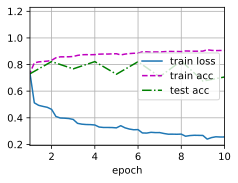

In [33]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [34]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.2063, 2.3385, 3.8999, 2.5862, 1.7510, 3.4714], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 1.6220,  2.4417, -2.2880,  1.7826,  1.9797,  3.7407], device='cuda:0',
        grad_fn=<ViewBackward0>))

### 7.5.5 简明实现

In [45]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),

    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),  # 这里是 1D  不是 2D!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),  # 这里是 1D  不是 2D!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    nn.Linear(84, 10)
)

training on cuda:0
loss 0.282, train acc 0.895, test acc 0.852
70702.9 examples/sec on cuda:0


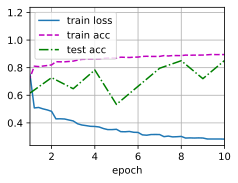

In [46]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())